### MTA Turnstile Data, April 19 vs April 20
#### Determine stations with the least traffic change.

* Scrape MTA turnstile data website
* Clean Turnstile data
* Calculate Change Rates
* Isolate Chagne Rate > -85%
* Combine Data with Open Data NYC Subway stops data set

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import lxml.html
import time
import datetime
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Scrape MTA turnstile data website

List of all available data : http://web.mta.info/developers/turnstile.html



In [3]:
mta_url = r'http://web.mta.info/developers/turnstile.html'
response = requests.get( mta_url) #Get the html content of the website

doc = lxml.html.fromstring(response.content)
#All links are stored in a single div. for each a, get the hrefs.
data_path = doc.xpath('//div[@class="span-84 last"]/a/@href') 

df_link = pd.DataFrame( data_path , columns = ['url'] ) #Pandas dataframe
df_link['url'] = ['http://web.mta.info/developers/' + row['url'] for index,row in df_link.iterrows() ] #Complete url

#Extract date and format, separate to year,month,day to filter easier in the future
df_link['date'] = [row['url'].split('_')[1].split('.txt')[0] for index,row in df_link.iterrows() ] #Complete url
df_link['date'] = pd.to_datetime( df_link.date , format = '%y%m%d')
df_link['year'] = df_link['date'].dt.year
df_link['month'] = df_link['date'].dt.month
df_link['day'] = df_link['date'].dt.day

print( len(data_path) , ' weeks data is available' )

520  weeks data is available


#### Import Data to a Pandas Dataframe
I will do this once to test with a single row. I am using a random date to test.

In [4]:
def downloadData(link):
    dfs = pd.read_csv( link , parse_dates=[['DATE', 'TIME']])
    dfs.columns = dfs.columns.str.lower().tolist()
    dfs.columns = [i.replace(" ",'') for i in dfs.columns]
    dfs['entries'] = dfs['entries'].astype(int)
    dfs['exits'] = dfs['exits'].astype(int)
    return dfs

dfs = downloadData(df_link.sample(1)['url'].tolist()[0]) #Testing using one.

#### Group by Date, Station and Line
I want to compare daily rates so I don't care about 4hr periods.
Data is given in cumulative sums in the data. I am reversing the sum.


In [5]:
def organizeData(dfs):
    gr = dfs.groupby(['c/a','unit','scp','station'])
    for diff_field in ('entries','exits'): #This bit is from https://github.com/lpalova/MTA-analysis/blob/master/Lucia-Benson-project.ipynb
        dfs[ diff_field + '_1' ] = gr[diff_field].transform(pd.Series.diff)
    
    dfs['date'] = dfs['date_time'].dt.date
    dfs = dfs.dropna(subset=['entries','exits'])
    dfs = dfs.drop(['entries','exits'], axis = 1)

    gr = dfs.groupby(by=['date','station','linename'] ,as_index = False ).sum()
    return gr

gr = organizeData(dfs) 

#### Visualize the data. 
I will use the 7 line as a test. 

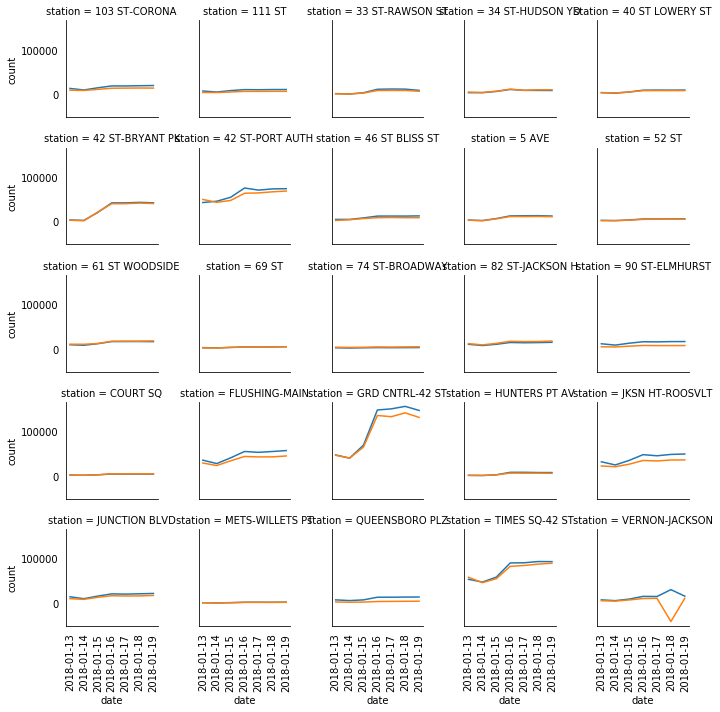

In [8]:
line = '7' 
t = gr[ gr.linename.str.contains( line ) ]
t = t.groupby( ['date','station'] ).sum()

t = t.stack().reset_index()
t.columns = t.columns[:-2].tolist() + ['direction','count'] 

#This takes a while
def lg(x,y,z, **kwargs): #Define lineplot with styling as function
    ax = sns.lineplot(x,y, hue = z)
    plt.xticks(rotation = 90)
    ax.tick_params(top=False, bottom=False, left=False, right=False )

g = sns.FacetGrid(t, col="station" , height=2,aspect=1, col_wrap = int(len(t.station.unique())**0.5) )
g = g.map( lg, 'date' , "count", 'direction' )


#### Use the definitions to get April,2020 and April,2019 data. 
I will use a sinlge week. This is currently the most recent data.

* Some stations return very odd numbers, there might be bit more work necessary

In [9]:
#4/2020
df_link_Apr20 = df_link[ (df_link.year == 2020) & (df_link.month == 4) ].copy()
df_link_Apr20 = df_link_Apr20.loc[0]

df_a20 = downloadData( df_link_Apr20['url'] )
gr_a20 = organizeData( df_a20 )
gr_a20['wd'] = pd.to_datetime( gr_a20['date']).dt.day_name()
gr_a20 = gr_a20[ (gr_a20['wd']!= 'Saturday') & (gr_a20['wd']!= 'Sunday') ] #Only weekdays
gr_a20_c = gr_a20.groupby( by = ['station','linename'] , as_index = False ).sum()
gr_a20_c.columns = gr_a20_c.columns[:2].tolist() + ['entries_20','exits_20']


#4/2019
df_link_Apr19 = df_link[ (df_link.year == 2019) & (df_link.month == 4) ].copy()
df_link_Apr19 = df_link_Apr19.iloc[1]
df_a19 = downloadData( df_link_Apr19['url'] )
gr_a19 = organizeData( df_a19 )
gr_a19['wd'] = pd.to_datetime( gr_a19['date']).dt.day_name()
gr_a19 = gr_a19[ (gr_a19['wd']!= 'Saturday') & (gr_a19['wd']!= 'Sunday') ]#Only weekdays
gr_a19_c = gr_a19.groupby( by = ['station','linename'] , as_index = False ).sum()
gr_a19_c.columns = gr_a19_c.columns[:2].tolist() + ['entries_19','exits_19']

birp = gr_a19_c.set_index( ['station','linename'] ).join( gr_a20_c.set_index( ['station','linename'] ) )
birp = birp.reset_index()

birp['ent_diff'] = birp['entries_20'] - birp['entries_19']
birp['ent_diff_perc'] = (birp['ent_diff'] / birp['entries_19']) * 100

birp = birp[ birp['entries_20']> 0 ]
birp = birp[ birp['entries_19']> 0 ]
birp = birp[birp.ent_diff<0]

birp['linename'] = ['-'.join(row) for i,row in birp['linename'].iteritems()]


#### Least & Most Traffic Change in percentage 

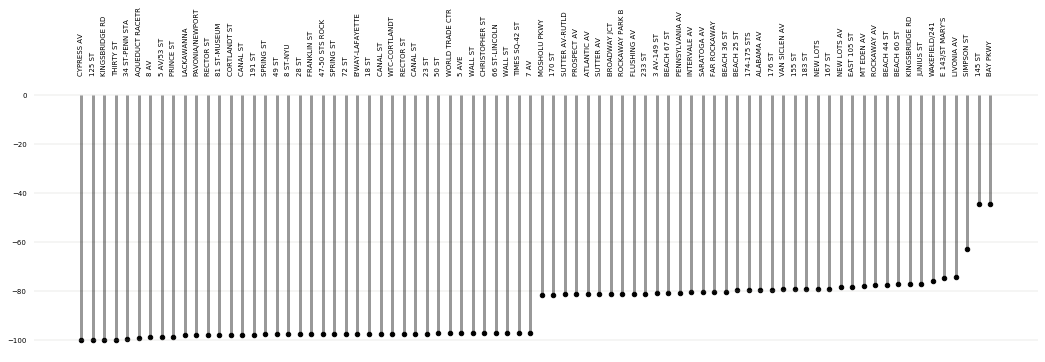

In [23]:
birp = birp.sort_values(by='ent_diff_perc' , ascending=True)
birp2 = birp.head(40).append( birp.tail(40) )
plt.rcParams['font.size'] = 7

plt.figure( figsize=(18,5))
plt.vlines(x=range(0,len(birp2)), ymin=0, ymax = birp2['ent_diff_perc'], color='black', alpha=0.4 , lw = 3)
plt.scatter( y=birp2['ent_diff_perc'] , x=range(0,len(birp2)) , color='black' , s=20)
plt.xticks(range(0,len(birp2)), birp2['station'] , rotation = 90)
plt.grid( axis = 'y' , color = '#b6b2ab', lw=0.25)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.tick_params(top=False, bottom=False, left=False, right=False, labeltop=True, labelbottom=False,labelleft=True)
plt.show()

#### Bring Shapefiles and Format
Format either data set to get them to match. There are multipple problems.

* Names do not match
* Intersections written in reverse
* Same station name repeats over different lines

In [25]:
import geopandas as gpd
#https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49
g_path = r"DATA\NYC\Subway_Stations\geo_export_e3c83426-c141-42a6-baf5-7fc8809d4967.shp"

stops = gpd.read_file( g_path )
stops['name'] = stops['name'].str.upper()

stops = stops[['line','name','geometry']]
stops['name'] = stops['name'].replace( 'AVE' , 'AV' , regex=True)
stops['name'] = stops['name'].replace( '1ST' , '1', regex=True)
stops['name'] = stops['name'].replace( '2ND' , '2', regex=True)
stops['name'] = stops['name'].replace( '3RD' , '3', regex=True)
stops['name'] = stops['name'].replace( '4TH' , '4', regex=True)
stops['name'] = stops['name'].replace( '5TH' , '5', regex=True)
stops['name'] = stops['name'].replace( '6TH' , '6', regex=True)
stops['name'] = stops['name'].replace( '7TH' , '7', regex=True)
stops['name'] = stops['name'].replace( '8TH' , '8', regex=True)
stops['name'] = stops['name'].replace( '9TH' , '9', regex=True)
stops['name'] = stops['name'].replace( '0TH' , '0', regex=True)
stops['line'] = stops['line'].replace( '-6 Express' , '', regex=True)
stops['line'] = stops['line'].replace( '-7 Express' , '', regex=True)
stops['name'] = stops['name'].replace( ' - ' , '-', regex=True)


birp['station'] = birp['station'].replace('/','-',regex = True)
birp['station'] = birp['station'].replace('EAST','E',regex = True)
birp['station'] = birp['station'].replace('WEST','W',regex = True)
birp['station'] = birp['station'].replace('WEST','W',regex = True)
birp['station'] = birp['station'].replace('CENTER','CTR',regex = True)
birp['station'] = birp['station'].replace('AVENUE','AV',regex = True)
birp['station'] = birp['station'].replace('WASH','WASHINGTON',regex = True)
birp['station'] = birp['station'].replace('CONC','CONCOURSE',regex = True)
birp['station'] = birp['station'].replace('YD','YARD',regex = True)


#### Match stations
This is an odd and a long way of matching data.
At the end I have 93 stations not matched

In [28]:
lat = []
lon = []

for i,row in birp.iterrows(): # If the station name and lines match well. 

    t = stops[ stops['line'] == row['linename'] ]
    t = t[ t['name'].str.contains( row['station'] )]
    
    if (len(t) == 0) and ('-' in row['station']):
        t = stops[ stops['line'].str.contains('|'.join( row['linename'].split('-') )) ]
        t = t[ t['name'] == (row['station'].split('-')[1] + '-' + row['station'].split('-')[0]) ]
        t = t.head(1)

    if(len(t) == 1 ):
        lat.append( t.geometry.y.values[0] )
        lon.append( t.geometry.x.values[0] ) 
        
    else:
        lat.append( None )
        lon.append( None )
    
birp['lat'] = lat
birp['lon'] = lon
    
bg = birp[ ~pd.isna(birp.lat) ].copy()
bn = birp[ pd.isna(birp.lat) ].copy()

lat = []
lon = []

for i,row in bn.iterrows(): # If they are not matching but can be.
    
    t = stops[ stops['line'].str.contains('|'.join( row['linename'].split('-') )) ]
    t = t[ t['name'].str.contains( row['station'] ) ]
    
    if(len(t) > 1 ): t = t.head(1)
    if(len(t) == 1 ):
        lat.append( t.geometry.y.values[0] )
        lon.append( t.geometry.x.values[0] )  
        
    else:
        lat.append( None )
        lon.append( None )
    
bn['lat'] = lat
bn['lon'] = lon

birp3 = bg.append( bn ) #There is 98 stations I was not able to match

123 103


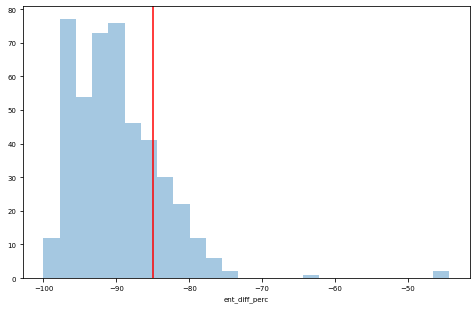

In [33]:
plt.figure( figsize = (8,5) )
sns.distplot( birp3['ent_diff_perc'] ,bins = 25 , kde = False )
plt.axvline( -85 , color = 'r')


In [ ]:
birp3[ birp3['ent_diff_perc'] > -85 ].to_csv(r'Subway_Diff.csv')